# 段階3: VGG (Very Deep Convolutional Networks) の実装

このノートブックでは、2014年のImageNet LSVRCで優れた成績を収めたVGGネットワークのアーキテクチャについて学び、その主要な設計思想である「小さな畳み込みカーネルの連続使用」と「ネットワークの深さ」の重要性を理解します。
NumPyで主要な概念を実装・確認した後、PyTorchを使ってCIFAR-10データセット用に調整したVGG風モデルを実装し、学習と評価を行います。

**参考論文:**
*   Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. *arXiv preprint arXiv:1409.1556*. (Published at ICLR 2015)

**このノートブックで学ぶこと:**
1.  VGGネットワークの設計思想とアーキテクチャの概要
2.  主要なコンポーネントの理解とNumPyによる概念実装:
    *   3x3畳み込みカーネルの連続使用による有効受容野の拡大とパラメータ効率
    *   1x1畳み込みカーネルの役割 (論文の構成Cより)
3.  PyTorchを使ったVGG風モデル（CIFAR-10用）の実装
4.  CIFAR-10データセットでの学習と評価

**前提知識:**
*   AlexNetのノートブックで学んだCNNの基礎とPyTorchによる実装経験

## 1. 必要なライブラリのインポート

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.5.0+cu124
Torchvision Version: 0.20.0+cu124
Using device: cuda


## 2. VGGの主要な設計思想とNumPyによる概念実装

VGGネットワークの最も際立った特徴は、非常に小さな3x3の畳み込みカーネルを一貫して使用し、層を深く積み重ねた点にあります。

### 2.1 小さな畳み込みカーネル (3x3) の連続使用

*   **概念:**
    VGG以前のCNN（例: AlexNet）では、比較的大きなカーネルサイズ（例: 11x11, 5x5）が最初の層で使われることがありました。VGGは、これらを3x3のカーネルのスタック（連続した適用）で置き換えることの利点を示しました。

    *   **有効受容野 (Effective Receptive Field):**
        *   3x3の畳み込みを2回連続して適用すると、有効受容野は5x5の畳み込み1回に相当します。
        *   3x3の畳み込みを3回連続して適用すると、有効受容野は7x7の畳み込み1回に相当します。
    *   **非線形性の増加:** 3x3の畳み込みを複数回適用する間に活性化関数（ReLUなど）を挟むことで、同じ受容野を持つ大きなカーネル1回よりも多くの非線形変換を導入でき、モデルの表現能力が向上します。
    *   **パラメータ数の削減:**
        例えば、入力と出力が共にCチャネルの場合:
        *   1層の5x5畳み込み: パラメータ数 = $5 \times 5 \times C \times C = 25 C^2$
        *   2層の3x3畳み込み: パラメータ数 = $2 \times (3 \times 3 \times C \times C) = 18 C^2$
        同様に、7x7畳み込み1層 ($49C^2$) は、3x3畳み込み3層 ($27C^2$) よりもパラメータ数が多くなります。
        これにより、より深いネットワークを少ないパラメータで構築できます。

*   **NumPyによる有効受容野の確認 (概念):**
    ここでは、畳み込み演算の出力サイズの変化を通じて、有効受容野の考え方を視覚化します。
    （実際の受容野は中央のピクセルがどの範囲の入力を見ているかですが、出力サイズの変化でも間接的に示せます）

In [8]:
def calculate_output_size(input_size, kernel_size, stride=1, padding=0):
    '''畳み込み後の出力サイズを計算'''
    return (input_size - kernel_size + 2 * padding) // stride + 1

print("--- 有効受容野の確認 (出力サイズの変化) ---")
input_dim = 7 # 例: 7x7の入力

# 3x3畳み込みを1回 (padding=0, stride=1)
out_3x3_1 = calculate_output_size(input_dim, 3) # (7-3)/1 + 1 = 5
print(f"7x7入力 -> 3x3 conv (1回) -> {out_3x3_1}x{out_3x3_1}出力")

# 3x3畳み込みを2回 (padding=0, stride=1)
out_3x3_2_intermediate = calculate_output_size(input_dim, 3) # 5x5
out_3x3_2_final = calculate_output_size(out_3x3_2_intermediate, 3) # (5-3)/1 + 1 = 3
print(f"7x7入力 -> 3x3 conv (2回) -> {out_3x3_2_final}x{out_3x3_2_final}出力 (有効受容野5x5に相当)")

# 5x5畳み込みを1回 (padding=0, stride=1)
out_5x5_1 = calculate_output_size(input_dim, 5) # (7-5)/1 + 1 = 3
print(f"7x7入力 -> 5x5 conv (1回) -> {out_5x5_1}x{out_5x5_1}出力")
# 3x3を2回重ねた場合と5x5を1回の場合で、同じ入力サイズから同じ出力サイズになることがわかります。

print("\n--- パラメータ数の比較 (Cチャネル入力、Cチャネル出力) ---")
C = 64 # 例
params_5x5_single = (5*5*C) * C + C # 重み + バイアス (出力チャネルごと)
params_3x3_double = 2 * ((3*3*C) * C + C)
print(f"5x5 conv 1層: {params_5x5_single} パラメータ (C={C})")
print(f"3x3 conv 2層: {params_3x3_double} パラメータ (C={C})")
print(f"削減率: {((params_5x5_single - params_3x3_double) / params_5x5_single) * 100:.2f}%")

--- 有効受容野の確認 (出力サイズの変化) ---
7x7入力 -> 3x3 conv (1回) -> 5x5出力
7x7入力 -> 3x3 conv (2回) -> 3x3出力 (有効受容野5x5に相当)
7x7入力 -> 5x5 conv (1回) -> 3x3出力

--- パラメータ数の比較 (Cチャネル入力、Cチャネル出力) ---
5x5 conv 1層: 102464 パラメータ (C=64)
3x3 conv 2層: 73856 パラメータ (C=64)
削減率: 27.92%


### 2.2 1x1畳み込みカーネルの利用 (VGG構成C)

*   **概念:**
    VGGの構成Cでは、3x3畳み込みの代わりに1x1畳み込みが一部で使用されています。
    1x1畳み込みは、空間的な情報を混ぜ合わせることはありませんが、チャネル方向に作用します。
    *   **チャネル間の線形変換・特徴の組み合わせ:** 入力チャネル数がC、出力チャネル数がDの1x1畳み込みは、各ピクセル位置において、C次元のベクトルをD次元のベクトルに線形変換する操作と見なせます。これは、チャネル間の特徴を線形的に組み合わせる効果があります。
    *   **次元削減・増加 (Bottleneck Layer):** 出力チャネル数を入力チャネル数より小さくすれば次元削減、大きくすれば次元増加が可能です。
    *   **非線形性の追加:** 1x1畳み込みの後にReLUなどの活性化関数を適用することで、追加の非線形性を導入できます（受容野は変わらないまま）。
    
    VGG構成Cでは、入力チャネル数と出力チャネル数を同じにした1x1畳み込みを使い、主に非線形性を追加する目的で挿入されています。

*   **NumPyによる1x1畳み込みの概念実装:**
    1x1畳み込みは、各ピクセル位置でチャネル間の全結合演算を行うことと等価です。

In [9]:
def convolve1x1(input_volume, kernels, biases):
    '''
    1x1畳み込み演算（多チャネル入力、多チャネル出力）
    parameters:
        input_volume: 入力ボリューム（入力チャネル数、高さ、幅）
        kernels: カーネル群（出力チャネル数、入力チャネル数、1, 1）
        biases: バイアス項 （出力チャネル数,）
    returns:
        np.array: 出力ボリューム（出力チャネル数、高さ、幅）
    '''
    n_input_channels, img_h, img_w = input_volume.shape
    n_output_channels, _, k_h, k_w = kernels.shape

    if k_h != 1 or k_w != 1:
        raise ValueError("Kernel size must be 1x1 for 1x1 convolution.")
    if n_input_channels != kernels.shape[1]:
        raise ValueError("Kernel input channels must match input volume channels.")
    if len(biases) != n_output_channels:
        raise ValueError("Biases length must match output channels.")

    # 出力サイズは入力サイズと同じ
    output_volume = np.zeros((n_output_channels, img_h, img_w))

    # 各ピクセル位置 (h, w) でチャネル間の線形変換を行う
    # input_volume[:, h, w] は (入力チャネル数,) のベクトル
    # kernels[:, :, 0, 0] は (出力チャネル数, 入力チャネル数) の行列
    # biases は (出力チャネル数,)

    # input_reshaped: (入力チャネル数, 高さ*幅）
    input_reshaped = input_volume.reshape(n_input_channels, img_h * img_w)
    # kernels_reshaped: (出力チャネル数, 入力チャネル数)
    kernels_reshaped = kernels.reshape(n_output_channels, n_input_channels)

    # output_linear_combination:（出力チャネル数, 高さ*幅）
    output_linear_combination = np.dot(kernels_reshaped, input_reshaped)

    # バイアスを加算（ブロードキャスト）
    output_biased = output_linear_combination + biases.reshape(-1, 1)

    # 出力を元の形状に戻す
    output_volume = output_biased.reshape(n_output_channels, img_h, img_w)

    return output_volume

In [10]:
# テスト
print("\n--- 1x1 畳み込みテスト ---")
# 2チャネル入力画像 (2x2)
test_input_1x1 = np.array([
    [[1,2], [3,4]], # Channel 0
    [[5,6], [7,8]]  # Channel 1
], dtype=np.float32)

# 3出力チャネルを生成する1x1カーネル群 (3出力チャネル, 2入力チャネル, 1, 1)
kernels_1x1 = np.array([
    [ [[0.5]], [[0.5]] ], # Out ch0 = 0.5*In_ch0 + 0.5*In_ch1
    [ [[1.0]], [[0.0]] ], # Out ch1 = 1.0*In_ch0 + 0.0*In_ch1
    [ [[0.0]], [[1.0]] ]  # Out ch2 = 0.0*In_ch0 + 1.0*In_ch1
], dtype=np.float32)
biases_1x1 = np.array([0.1, 0.2, 0.3], dtype=np.float32)

output_1x1 = convolve1x1(test_input_1x1, kernels_1x1, biases_1x1)
print("1x1畳み込み入力 (2x2x2):\n", test_input_1x1)
# print("\n1x1カーネル (3x2x1x1):\n", kernels_1x1)
# print("\n1x1バイアス (3,):\n", biases_1x1)
print("\n1x1畳み込み出力 (3x2x2):\n", output_1x1)
# 例: 出力のチャネル0、位置(0,0) は 0.5*1 + 0.5*5 + 0.1 = 0.5 + 2.5 + 0.1 = 3.1


--- 1x1 畳み込みテスト ---
1x1畳み込み入力 (2x2x2):
 [[[1. 2.]
  [3. 4.]]

 [[5. 6.]
  [7. 8.]]]

1x1畳み込み出力 (3x2x2):
 [[[3.1 4.1]
  [5.1 6.1]]

 [[1.2 2.2]
  [3.2 4.2]]

 [[5.3 6.3]
  [7.3 8.3]]]


## 3. VGG アーキテクチャの概要

VGGネットワークにはいくつかの構成（A, A-LRN, B, C, D, E）があり、深さが11層（VGG11、構成A）から19層（VGG19、構成E）まであります。
全ての構成で共通しているのは、
*   入力画像サイズ: 224x224x3 (RGB)
*   畳み込み層: 3x3カーネル（一部構成Cで1x1）、ストライド1、padding 'same'（出力サイズ維持のためpadding=1）
*   活性化関数: ReLU
*   プーリング層: 2x2 マックスプーリング、ストライド2
*   全結合層: 最後に3つの全結合層（4096ユニット、4096ユニット、1000ユニット（ImageNetクラス数））
*   最終層: Softmax

**VGG16 (構成D) の例:**
(conv3-64 は3x3畳み込み、64チャネル出力を意味する)
1.  Input (224x224x3)
2.  conv3-64, conv3-64, ReLU, MaxPool (→ 112x112x64)
3.  conv3-128, conv3-128, ReLU, MaxPool (→ 56x56x128)
4.  conv3-256, conv3-256, conv3-256, ReLU, MaxPool (→ 28x28x256)
5.  conv3-512, conv3-512, conv3-512, ReLU, MaxPool (→ 14x14x512)
6.  conv3-512, conv3-512, conv3-512, ReLU, MaxPool (→ 7x7x512)
7.  Flatten
8.  FC-4096, ReLU, Dropout
9.  FC-4096, ReLU, Dropout
10. FC-1000, Softmax

今回はCIFAR-10 (32x32x3) を対象とするため、このアーキテクチャをスケールダウンして適用します。

## 4. PyTorchによるVGG風モデルの実装とCIFAR-10での学習・評価

CIFAR-10データセット（32x32のカラー画像、10クラス）用に調整したVGG風モデルを実装します。
VGG11またはVGG13程度の深さのモデルを参考にします。

In [11]:
# CIFAR-10 データセットの準備 (AlexNetノートブックと同様)
transform_cifar_vgg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10の平均と標準偏差
])

train_dataset_cifar_vgg = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                       download=True, transform=transform_cifar_vgg)
test_dataset_cifar_vgg = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                      download=True, transform=transform_cifar_vgg)

batch_size_cifar_vgg = 128 
train_loader_cifar_vgg = DataLoader(train_dataset_cifar_vgg, batch_size=batch_size_cifar_vgg, shuffle=True, num_workers=2)
test_loader_cifar_vgg = DataLoader(test_dataset_cifar_vgg, batch_size=batch_size_cifar_vgg, shuffle=False, num_workers=2)

classes_cifar_vgg = ('plane', 'car', 'bird', 'cat', 'deer', 
                     'dog', 'frog', 'horse', 'ship', 'truck')

print(f"CIFAR-10 訓練データ数: {len(train_dataset_cifar_vgg)}, テストデータ数: {len(test_dataset_cifar_vgg)}")

100%|██████████| 170M/170M [00:23<00:00, 7.30MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-10 訓練データ数: 50000, テストデータ数: 10000


In [12]:
# VGGの構成を定義する辞書 (VGG11, VGG13, VGG16, VGG19)
# 各要素は畳み込み層のチャネル数、'M'はマックスプーリング層
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG_CIFAR(nn.Module):
    def __init__(self, vgg_name, num_classes=10, batch_norm=False): # バッチ正規化もオプションで追加
        super(VGG_CIFAR, self).__init__()
        self.features = self._make_layers(cfg[vgg_name], batch_norm)
        # CIFAR-10の場合、5回のプーリングで 32 -> 16 -> 8 -> 4 -> 2 -> 1
        # なので、最終的な特徴マップのサイズは 1x1 になる。チャネル数は最後の畳み込み層の出力(512)。
        # よって、全結合層の入力は 512 * 1 * 1 = 512
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 512), # VGG論文では4096だがCIFAR-10では大きすぎる可能性
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg_list, batch_norm=False):
        layers = []
        in_channels = 3 # CIFAR-10の入力チャネル数
        for x in cfg_list:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1)]
                if batch_norm:
                    layers += [nn.BatchNorm2d(x)]
                layers += [nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

In [13]:
# VGG11モデルのインスタンス化 (CIFAR-10用)
model_vgg_cifar = VGG_CIFAR('VGG11', num_classes=10, batch_norm=True).to(device)
print("\nVGG-style Model for CIFAR-10 (VGG11 with Batch Norm):\n")
# print(model_vgg_cifar) # モデル構造が長いため、必要に応じてコメントアウト解除

# ダミー入力でのフォワードパスのテスト
dummy_input_vgg = torch.randn(batch_size_cifar_vgg // 2, 3, 32, 32).to(device)
output_dummy_vgg = model_vgg_cifar(dummy_input_vgg)
print("\nCIFAR Dummy Input Shape (VGG):", dummy_input_vgg.shape)


VGG-style Model for CIFAR-10 (VGG11 with Batch Norm):


CIFAR Dummy Input Shape (VGG): torch.Size([64, 3, 32, 32])


In [14]:
# 損失関数とOptimizer
criterion_vgg = nn.CrossEntropyLoss()
# optimizer_vgg = optim.SGD(model_vgg_cifar.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
optimizer_vgg = optim.Adam(model_vgg_cifar.parameters(), lr=0.001) # Adamの方が初期収束が早いことが多い

# 学習率スケジューラ (オプション)
# scheduler_vgg = torch.optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1) # 例: 7エポックごとに学習率を0.1倍

# 学習ループ
num_epochs_vgg = 30 # VGGは学習に時間がかかるのでエポック数を調整
print(f"\nVGG-style 学習開始 (CIFAR-10データ、{num_epochs_vgg} epochs)...")

history_vgg = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

for epoch in range(num_epochs_vgg):
    model_vgg_cifar.train() # モデルを訓練モードに設定
    
    # --- 訓練フェーズ ---
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    start_epoch_time = time.time()
    
    for i, (images, labels) in enumerate(train_loader_cifar_vgg):
        images = images.to(device)
        labels = labels.to(device)
        
        # 勾配を0に初期化
        optimizer_vgg.zero_grad()
        
        # 順伝播
        outputs = model_vgg_cifar(images)
        
        # 損失計算
        loss = criterion_vgg(outputs, labels)
        
        # 逆伝播
        loss.backward()
        
        # パラメータ更新
        optimizer_vgg.step()
        
        running_train_loss += loss.item() * images.size(0) # バッチロス * バッチサイズ
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_train_loss / total_train
    epoch_train_acc = 100 * correct_train / total_train
    history_vgg['train_loss'].append(epoch_train_loss)
    history_vgg['train_acc'].append(epoch_train_acc)
    
    # --- 評価フェーズ ---
    model_vgg_cifar.eval() # モデルを評価モードに設定
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad(): # 勾配計算を無効にする
        for images_test, labels_test in test_loader_cifar_vgg:
            images_test = images_test.to(device)
            labels_test = labels_test.to(device)
            
            outputs_test = model_vgg_cifar(images_test)
            loss_test = criterion_vgg(outputs_test, labels_test)
            running_test_loss += loss_test.item() * images_test.size(0) # バッチロス * バッチサイズ
            
            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()
            
    epoch_test_loss = running_test_loss / total_test
    epoch_test_acc = 100 * correct_test / total_test
    history_vgg['test_loss'].append(epoch_test_loss)
    history_vgg['test_acc'].append(epoch_test_acc)
    
    end_epoch_time = time.time()
    epoch_duration = end_epoch_time - start_epoch_time
    
    print(f"Epoch [{epoch+1}/{num_epochs_vgg}] - Duration: {epoch_duration:.2f}s - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")
    
    # if scheduler_vgg: scheduler_vgg.step() # 学習率スケジューラを更新

print("VGG-style 学習完了!")


VGG-style 学習開始 (CIFAR-10データ、30 epochs)...
Epoch [1/30] - Duration: 24.46s - Train Loss: 1.6768, Train Acc: 32.95% - Test Loss: 1.4141, Test Acc: 47.80%
Epoch [2/30] - Duration: 23.99s - Train Loss: 1.1936, Train Acc: 56.84% - Test Loss: 1.1226, Test Acc: 60.64%
Epoch [3/30] - Duration: 23.79s - Train Loss: 0.9201, Train Acc: 68.48% - Test Loss: 0.8789, Test Acc: 68.98%
Epoch [4/30] - Duration: 24.07s - Train Loss: 0.7724, Train Acc: 74.29% - Test Loss: 0.8365, Test Acc: 71.62%
Epoch [5/30] - Duration: 24.19s - Train Loss: 0.6528, Train Acc: 78.71% - Test Loss: 0.7136, Test Acc: 76.56%
Epoch [6/30] - Duration: 23.94s - Train Loss: 0.5585, Train Acc: 82.13% - Test Loss: 0.6929, Test Acc: 77.84%
Epoch [7/30] - Duration: 23.84s - Train Loss: 0.4739, Train Acc: 84.64% - Test Loss: 0.7628, Test Acc: 76.69%
Epoch [8/30] - Duration: 24.60s - Train Loss: 0.4040, Train Acc: 87.33% - Test Loss: 0.6056, Test Acc: 81.19%
Epoch [9/30] - Duration: 24.40s - Train Loss: 0.3383, Train Acc: 89.44% - Tes

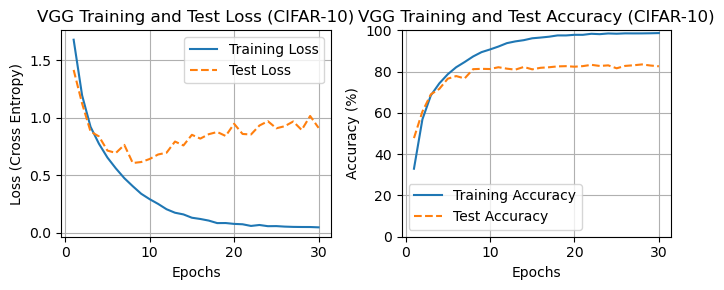


最終テスト精度 (VGG-style on CIFAR-10): 82.58%
最終訓練精度 (VGG-style on CIFAR-10): 98.67%
最終テスト損失 (VGG-style on CIFAR-10): 0.9110
最終訓練損失 (VGG-style on CIFAR-10): 0.0467


In [17]:
# 学習曲線 (損失と精度) のプロット
plt.figure(figsize=(7, 3))

# 損失のプロット
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_vgg + 1), history_vgg['train_loss'], label='Training Loss', linestyle='-')
plt.plot(range(1, num_epochs_vgg + 1), history_vgg['test_loss'], label='Test Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.title('VGG Training and Test Loss (CIFAR-10)')
plt.legend()
plt.grid(True)

# 精度のプロット
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_vgg + 1), history_vgg['train_acc'], label='Training Accuracy', linestyle='-')
plt.plot(range(1, num_epochs_vgg + 1), history_vgg['test_acc'], label='Test Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('VGG Training and Test Accuracy (CIFAR-10)')
plt.legend()
plt.ylim(0, 100) # 精度は0-100%
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n最終テスト精度 (VGG-style on CIFAR-10): {history_vgg['test_acc'][-1]:.2f}%")
print(f"最終訓練精度 (VGG-style on CIFAR-10): {history_vgg['train_acc'][-1]:.2f}%")
print(f"最終テスト損失 (VGG-style on CIFAR-10): {history_vgg['test_loss'][-1]:.4f}")
print(f"最終訓練損失 (VGG-style on CIFAR-10): {history_vgg['train_loss'][-1]:.4f}")

## 5. 考察

*   **VGGの設計思想のポイント:**
    *   **深さの追求:** VGGは、畳み込み層を深く積み重ねることでモデルの表現能力を高め、性能を向上させるという方向性を示しました。
    *   **3x3カーネルの徹底:** ほぼ全ての畳み込み層で3x3という非常に小さなカーネルを使用しています。これにより、同等の受容野を持つ大きなカーネルよりもパラメータ数を抑えつつ、非線形性を多く導入できます。
    *   **アーキテクチャの単純さと規則性:** VGGの構成は、いくつかの畳み込み層とReLUのブロックの後にマックスプーリング層を配置するというパターンの繰り返しであり、非常に理解しやすく、実装も比較的容易です。
    *   **1x1畳み込みの利用 (構成C):** 受容野を変えずに非線形性を追加したり、チャネル数を調整したりする手段として1x1畳み込みが有効であることを示唆しました（後のGoogLeNetではより積極的に活用されます）。

*   **PyTorchによるVGG風モデルの実装:**
    *   `nn.Sequential` を使うことで、VGGの規則的な層のスタックを簡潔に記述できました。
    *   構成定義（`cfg`辞書）に基づいて動的に層を生成するヘルパー関数 `_make_layers` を用いることで、異なる深さのVGGバリアントを容易に作成できます。
    *   CIFAR-10用に全結合層の入力ユニット数を調整する必要がありましたが、これは最後のプーリング層の出力特徴マップのサイズから計算できます。今回の実装では、5回のプーリングにより $32 \rightarrow 16 \rightarrow 8 \rightarrow 4 \rightarrow 2 \rightarrow 1$ となり、最終的な特徴マップサイズが $1 \times 1$ になるように設計されています。
    *   バッチ正規化 (`nn.BatchNorm2d`) はVGGの原論文にはありませんでしたが、現代的な深いCNNでは学習の安定化と高速化に非常に有効であり、オプションとして追加しました。学習曲線を見ることで、その効果（過学習の抑制や収束の速さなど）を比較できます。

*   **学習結果と課題:**
    *   学習曲線（損失と精度）を訓練データとテストデータの両方についてプロットすることで、モデルが適切に学習しているか、過学習が発生していないかなどを視覚的に確認できます。
    *   訓練精度が高く、テスト精度が低い場合は過学習の兆候です。その場合、Dropoutの調整、Weight Decayの強化、Data Augmentationの導入、バッチ正規化の利用などが対策として考えられます。
    *   訓練損失が十分に下がらなかったり、テスト精度が頭打ちになったりする場合は、学習率の調整、Optimizerの変更、エポック数の増加、モデルの表現能力（層の数やチャネル数）の見直しなどを検討します。
    *   CIFAR-10のような比較的小さなデータセットであっても、VGG11程度の深さのモデルは、適切な正則化やバッチ正規化を用いることで、良好な性能を達成できます。

VGGは、そのシンプルさと深さの追求により、CNNアーキテクチャ設計における重要なマイルストーンとなりました。この後に登場するGoogLeNetやResNetは、VGGの思想を引き継ぎつつ、さらに効率的で高性能なネットワーク構造を探求していくことになります。